In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from matplotlib.colors import LogNorm
import yaml
from os.path import join

In [68]:
all_p_val = xr.open_dataset('/glade/derecho/scratch/cbecker/SEALS_output/2024-08-06_1432/loc_rate_block_transformer_output_2024-08-06_1432_val.nc')
all_p_train = xr.open_dataset('/glade/derecho/scratch/cbecker/SEALS_output/2024-08-06_1432/loc_rate_block_transformer_output_2024-08-06_1432_train.nc')
blind_p_val = xr.open_dataset('/glade/derecho/scratch/cbecker/SEALS_output/2024-08-06_1154/loc_rate_block_transformer_output_2024-08-06_1154_val.nc')
blind_p_train = xr.open_dataset('/glade/derecho/scratch/cbecker/SEALS_output/2024-08-06_1154/loc_rate_block_transformer_output_2024-08-06_1154_train.nc')

In [69]:
with open('/glade/derecho/scratch/cbecker/SEALS_output/2024-08-06_1432/train.yml') as cfg:
    config = yaml.safe_load(cfg)
print(config['data_path'])
config['loc_rate_block_transformer']

/glade/work/cbecker/seals-ml/Large_Training_Set_SBL_07-2024


{'compile': {'loss': ['binary_crossentropy', 'mean_absolute_error'],
  'loss_weights': [4.0, 1e-05]},
 'fit': {'batch_size': 36, 'epochs': 100, 'verbose': 1},
 'kwargs': {'block_size': 20,
  'data_start_index': 4,
  'decoder_layers': 3,
  'dropout_rate': 0.1,
  'encoder_layers': 4,
  'hidden_activation': 'leaky_relu',
  'hidden_size': 256,
  'n_coords': 3,
  'n_heads': 8,
  'n_outputs': 1,
  'output_activation': 'softmax'},
 'loss_weight_change': {'loss_weights': [1.0, 0.05], 'shift_epoch': 35},
 'optimizer': {'adam_beta_1': 0.9,
  'adam_beta_2': 0.999,
  'epsilon': 1e-07,
  'learning_rate': 0.0001,
  'optimizer_type': 'adam',
  'sgd_momentum': 0}}

In [70]:
for text, d in zip(["All TRAIN",  "All VALIDATION", "Subset TRAIN",  "Subset VALIDATION"], [all_p_train, all_p_val, blind_p_train, blind_p_val]):
    y_true = d['target_pot_loc'].argmax(axis=1).values
    y_pred = d['leak_loc_pred'].argmax(axis=1).values
    y_pred_k = d['leak_loc_pred'].values

    print(f"{text} Top-1 Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"{text} Top-2 Accuracy: {top_k_accuracy_score(y_true, y_pred_k, k=2, labels=np.arange(38))}")
    print(f"{text} Top-3 Accuracy: {top_k_accuracy_score(y_true, y_pred_k, k=3, labels=np.arange(38))}\n")

All TRAIN Top-1 Accuracy: 0.5643432784636488
All TRAIN Top-2 Accuracy: 0.7601630372656607
All TRAIN Top-3 Accuracy: 0.8453682270233196

All VALIDATION Top-1 Accuracy: 0.2912665752171925
All VALIDATION Top-2 Accuracy: 0.4971707818930041
All VALIDATION Top-3 Accuracy: 0.6415037722908093

Subset TRAIN Top-1 Accuracy: 0.6271159655214452
Subset TRAIN Top-2 Accuracy: 0.8538680007766254
Subset TRAIN Top-3 Accuracy: 0.9396941360268387

Subset VALIDATION Top-1 Accuracy: 0.3400557555226198
Subset VALIDATION Top-2 Accuracy: 0.5813924765332769
Subset VALIDATION Top-3 Accuracy: 0.7382842825887501



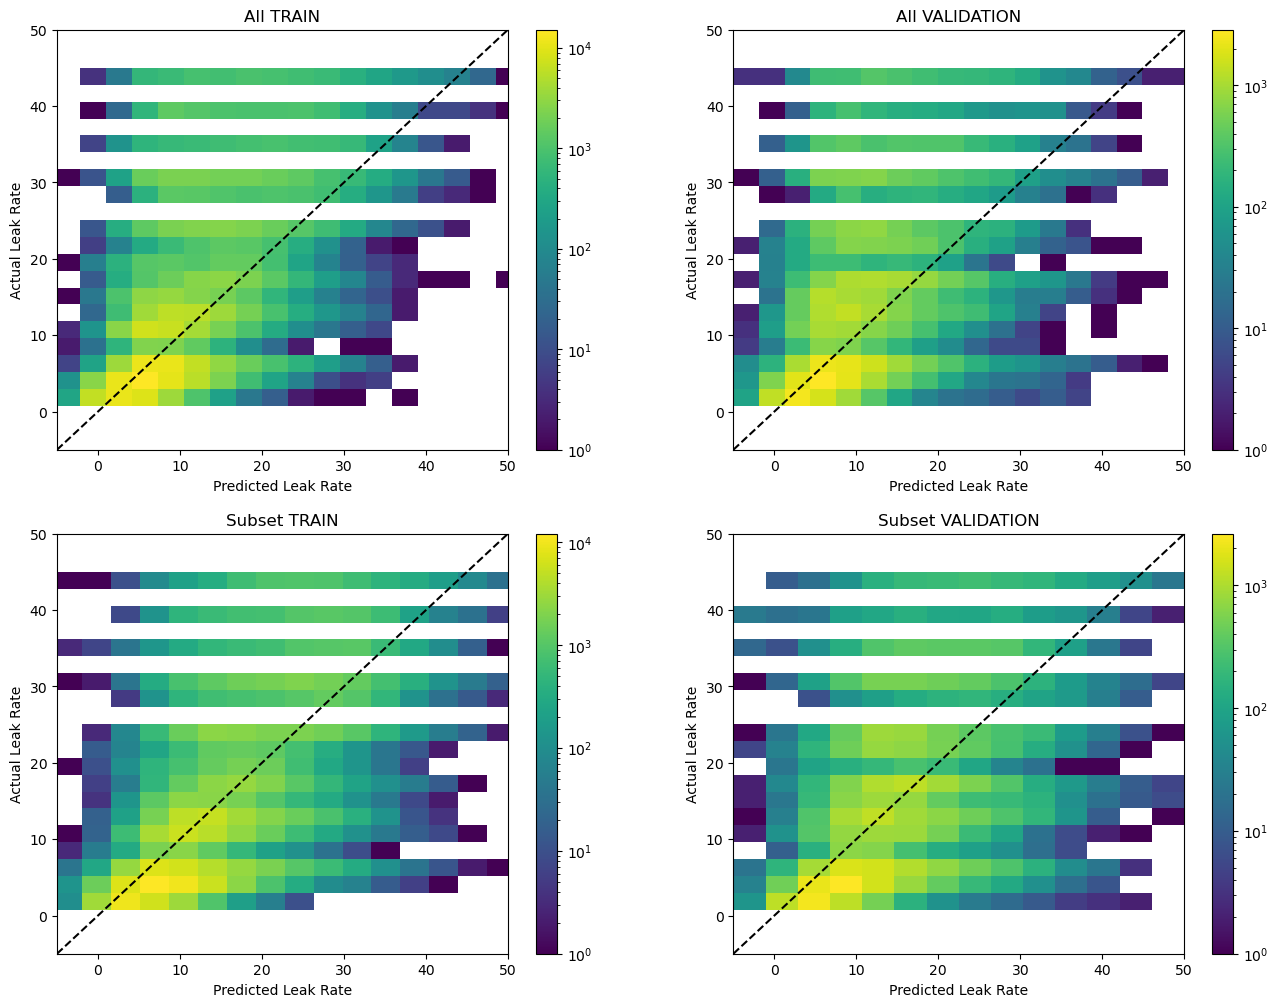

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
titles = ["All TRAIN",  "All VALIDATION", "Subset TRAIN",  "Subset VALIDATION"]
data = [all_p_train, all_p_val, blind_p_train, blind_p_val]
for i, ax in enumerate(axes.ravel()):
    im = ax.hist2d(data[i]['leak_rate_pred'], data[i]['target_leak_rate'], bins=(20, 20), cmap='viridis', norm=LogNorm())
    ax.set_title(titles[i])
    ax.axline((0, 0), slope=1, linestyle="--", color='k')
    ax.set_ylim(-5, 50)
    ax.set_xlim(-5, 50)
    ax.set_xlabel('Predicted Leak Rate')
    ax.set_ylabel('Actual Leak Rate')
    plt.colorbar(im[-1], ax=ax)
plt.show()

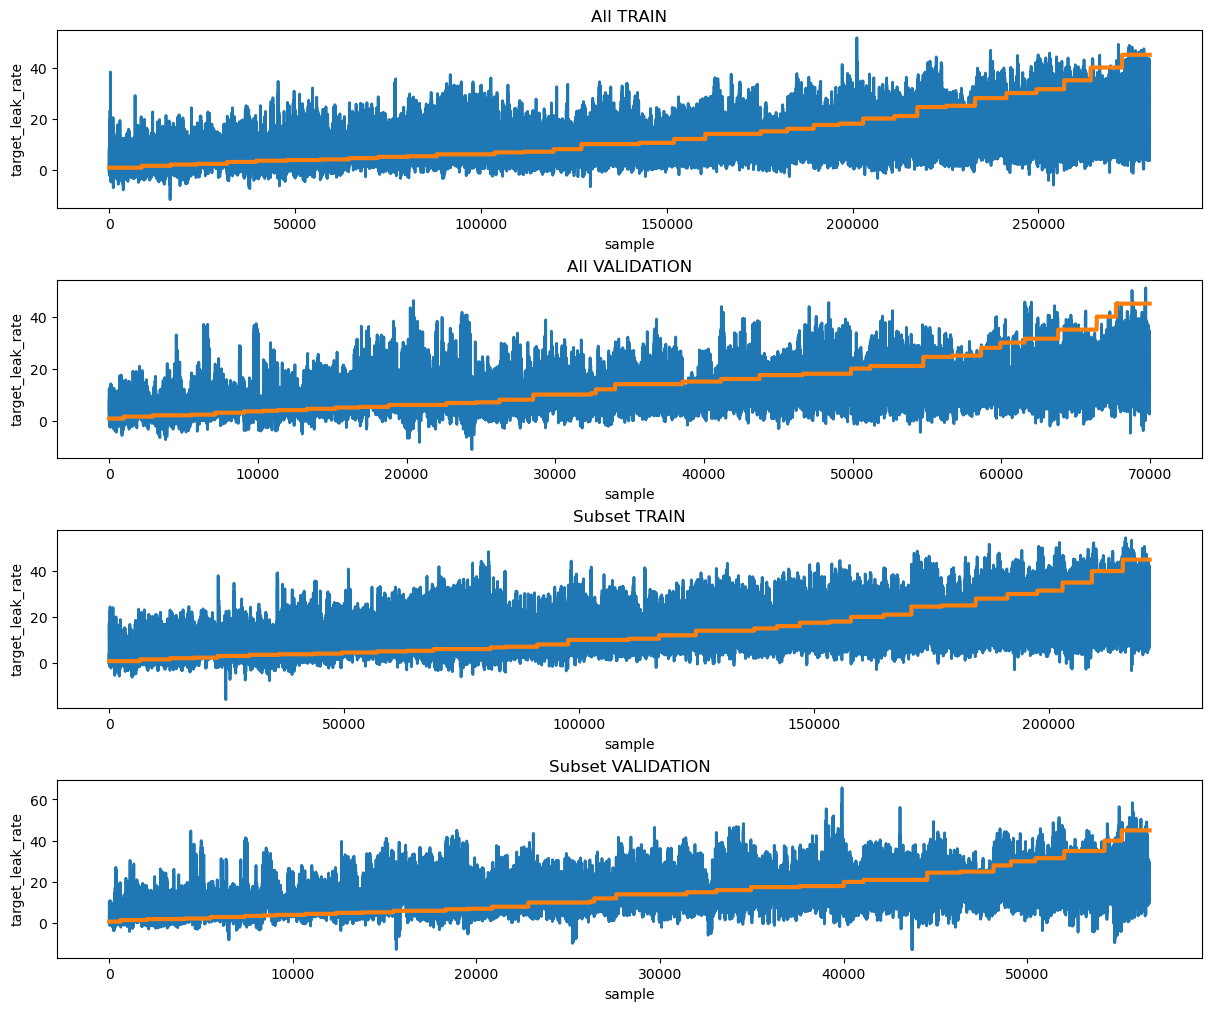

In [72]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), constrained_layout=True)
for i, ax in enumerate(axes.ravel()):
    data[i]['leak_rate_pred'][data[i]['target_leak_rate'].argsort()].plot(linewidth=2, ax=ax)
    data[i]['target_leak_rate'][data[i]['target_leak_rate'].argsort()].plot(linewidth=3, ax=ax)
    ax.set_title(titles[i])
plt.show()

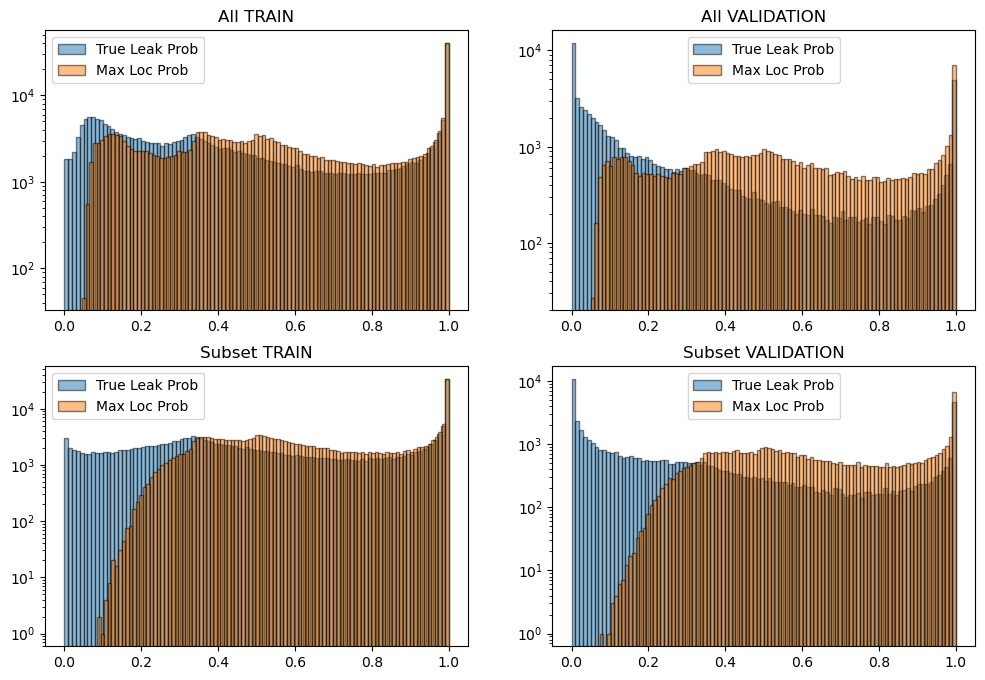

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.ravel()):
    true_i = data[i]['target_pot_loc'].argmax(axis=1)
    max_prob_i = data[i]['leak_loc_pred'].argmax(axis=1)
    
    true_prob = data[i]['leak_loc_pred'][np.arange(data[i]['target_pot_loc'].shape[0]), true_i]
    max_prob = data[i]['leak_loc_pred'].max(axis=1)

    ax.hist(true_prob, bins=100, edgecolor='k', log=True,alpha=0.5, label='True Leak Prob')
    ax.hist(max_prob, bins=100, edgecolor='k', log=True, alpha=0.5, label='Max Loc Prob')
    ax.set_title(titles[i])
    ax.legend()

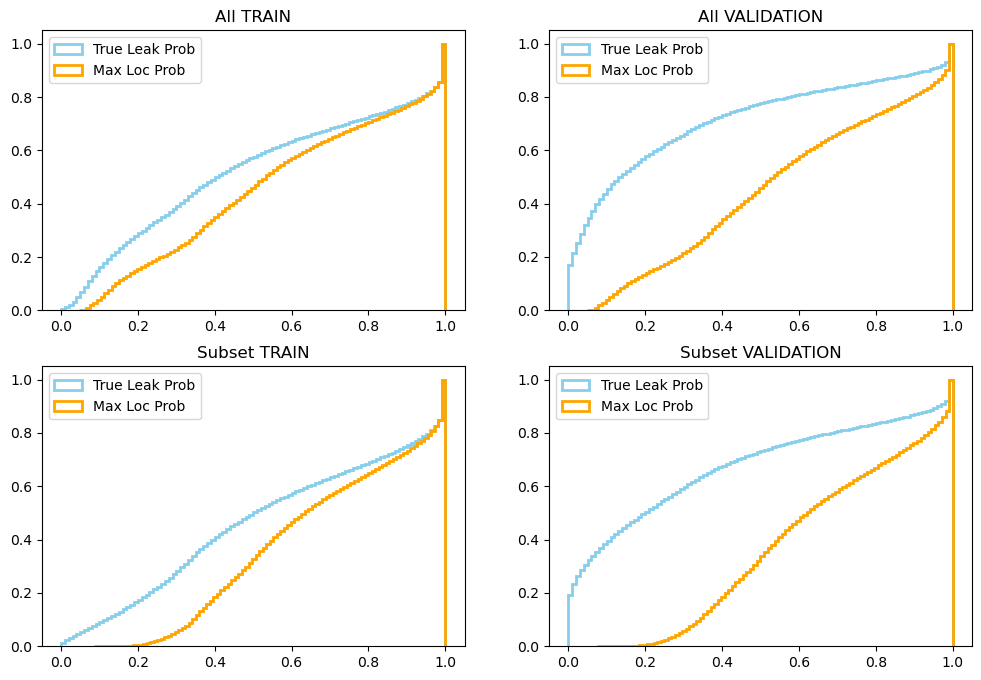

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.ravel()):
    true_i = data[i]['target_pot_loc'].argmax(axis=1)
    max_prob_i = data[i]['leak_loc_pred'].argmax(axis=1)
    
    true_prob = data[i]['leak_loc_pred'][np.arange(data[i]['target_pot_loc'].shape[0]), true_i]
    max_prob = data[i]['leak_loc_pred'].max(axis=1)

    ax.hist(true_prob, bins=100, density=True, cumulative=True, edgecolor='skyblue', histtype='step', linewidth=2, label='True Leak Prob')
    ax.hist(max_prob, bins=100, density=True, cumulative=True, edgecolor='orange', histtype='step', linewidth=2, label='Max Loc Prob')
    ax.set_title(titles[i])
    ax.legend()